In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, read_csv
from arviz import hdi
sns.set_theme(style='white', context='notebook', font_scale=1.33)

## Section 1: Traditional Model Evaluation

In [2]:
## Load diagnostic info.
diagnostics = read_csv(os.path.join('stan_results', 'X2.csv'))
diagnostics = diagnostics.set_index(['study','model']).round(3)

## Format chi-square.
diagnostics.insert(0, 'X2', diagnostics.apply(lambda x: f'%0.0f (%0.0f)' %(x.x2, x.df), 1))
diagnostics = diagnostics.drop(columns=['x2','df'])

## Present diagnostic information.
diagnostics

X2  rmsea    cfi    tli
study        model                                 
teicher2015  1      1858 (702)  0.040  0.927  0.923
             2      1373 (663)  0.032  0.955  0.950
             3      1571 (692)  0.035  0.944  0.940
             4      1253 (687)  0.028  0.964  0.961
tuominen2022 1      1086 (702)  0.031  0.954  0.952
             2       956 (663)  0.028  0.965  0.961
             3       881 (692)  0.022  0.977  0.976
             4       842 (687)  0.020  0.982  0.980

## Section 2: Posterior Predictive Model Checking

### 1.1 Observed score distribution

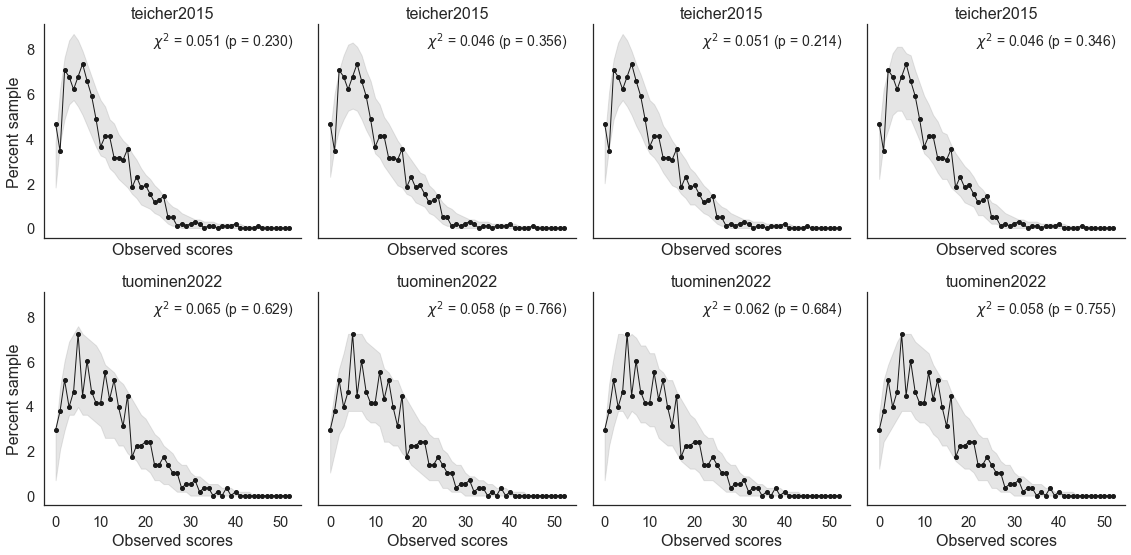

In [3]:
from arviz import hdi

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define I/O parameters.
studies = ['teicher2015','tuominen2022']
models = [1,2,3,4]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
nrow = len(studies)
ncol = len(models)
fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*4,nrow*4), sharex=True, sharey=True)
axes = np.atleast_2d(axes)

## Preallocate space.
ppmc = []

for j, m in enumerate(models):
    
    for i, study in enumerate(studies):

        ## Load posterior predictive check.
        df = read_csv(os.path.join('stan_results', study, f'grmq_m{m}_nc.csv'), index_col=0)

        ## Normalize counts across samples.
        df.loc[:,:] /= df.loc[0].values.sum()

        ## Extract values.
        NC  = df.values[0]
        NCr = df.values[1:]
        ENC = NCr.mean(axis=0)

        ## Compute 95% HDI.
        lb, ub = np.apply_along_axis(hdi, 0, NCr, hdi_prob=0.95)

        ## Compute chi-square statistics.
        xi = np.sum(np.divide(np.square(NC - ENC), ENC, where=ENC > 0))
        xr = np.divide(np.square(NCr - ENC), ENC, where=ENC > 0).sum(axis=1)

        ## Compute ppp-value.
        pppv = (xi <= xr).mean()

        ## Store statistics.
        ppmc.append(dict(study=study, model=m, xi=xi, xr=xr.mean(), pval=pppv))
        
        ## Plot observed scores and 95% HDI.
        axes[i,j].plot(np.arange(NC.size), NC, 'o-', color='k', lw=1, markersize=4)    
        axes[i,j].fill_between(np.arange(NC.size), lb, ub, color='0.5', alpha=0.2)

        ## Add detail.
        axes[i,j].set(xticks=np.arange(0,51,10), xlabel='Observed scores', 
                      yticks=np.arange(0,0.09,0.02), yticklabels=np.arange(0,9,2),
                      ylabel='', title=study)
        if not j: axes[i,j].set_ylabel('Percent sample')

        ## Add annotations.
        axes[i,j].annotate(r'$\chi^2$ = %0.3f (p = %0.3f)' %(xi, pppv), (0,0), (0.97, 0.97), 
                           xycoords='axes fraction', ha='right', va='top', fontsize=14)
    
## Convert to DataFrame.
ppmc = DataFrame(ppmc).sort_values(['study', 'model']).set_index(['study','model'])
ppmc = ppmc.round(3)
    
sns.despine()
plt.tight_layout()

### 1.2 $Q_3$-index

In [4]:
## Load Q3 indices.
Q3 = read_csv(os.path.join('stan_results', 'Q3.csv'))
    
## Compute number of locally-dependent pairs.
n_pairs = Q3.groupby(['study','model']).apply(lambda x: np.sum(x.Q3 > x.Q3_99.max()))
    
## Summarize Q3 indices.
Q3 = Q3.groupby(['study','model']).agg({'Q3':np.max, 'Q3_99':np.max}).round(3)
Q3 = Q3.merge(n_pairs.rename('n_pair'), left_index=True, right_index=True)

## Present Q3 indices.
Q3

Q3  Q3_99  n_pair
study        model                      
teicher2015  1      0.589  0.239      25
             2      0.573  0.300      10
             3      0.591  0.255      16
             4      0.591  0.279       8
tuominen2022 1      0.513  0.250      21
             2      0.456  0.310       4
             3      0.468  0.316       5
             4      0.437  0.318       1

## Section 2: Model Comparison

In [5]:
from itertools import combinations

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define I/O parameters.
studies = ['teicher2015','tuominen2022']
models = [1,2,3,4]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Main loop.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
loocv = []

for study in studies:

    for m in models:
        
        ## Load data.
        df = read_csv(os.path.join('stan_results', study, f'grmq_m{m}_ppmc.csv'))
        
        ## Compute LOO-CV.
        loo = -2 * df.loo.sum()
        
        ## Append.
        loocv.append(dict(study=study, model=m, loo=loo))
        
## Convert to DataFrame.
loocv = DataFrame(loocv).sort_values(['study', 'model']).set_index(['study','model']).round(1)

## Iteratively add comparison.
loocv['delta'] = '-'
for study in studies:
    
    ## Load winning model.
    x = read_csv(os.path.join('stan_results', study, f'grmq_m4_ppmc.csv'))
    
    for m in [1,2,3]:
        
        ## Load alternate model.
        y = read_csv(os.path.join('stan_results', study, f'grmq_m{m}_ppmc.csv'))
        
        ## Compute delta-LOO.
        arr = (-2*x.loo) - (-2*y.loo)
        mu = np.sum(arr)
        se = np.std(arr) * np.sqrt(len(x))
        
        ## Store.
        loocv.loc[(study,m),'delta'] = '%0.1f (%0.1f)' %(mu, se)
    
## Display DataFrame.
loocv

loo           delta
study        model                         
teicher2015  1      30967.2  -1748.0 (76.7)
             2      29211.3      7.9 (56.3)
             3      30531.1  -1312.0 (68.0)
             4      29219.2               -
tuominen2022 1      19771.6  -1089.3 (58.4)
             2      18706.2    -24.0 (52.0)
             3      19177.7   -495.5 (45.0)
             4      18682.2               -

## Section 3: Tables & Figures

### 3.1 Table 1

In [6]:
## Merge DataFrames.
table = diagnostics.merge(ppmc, left_index=True, right_index=True)
table = table.merge(Q3, left_index=True, right_index=True)
table = table.merge(loocv, left_index=True, right_index=True)

## Format columns.
table['xi'] = table.apply(lambda x: f'%0.3f (%0.3f)' %(x.xi, x.pval), axis=1)
table = table.drop(columns=['xr','pval','n_pair'])

## Display DataFrame.
table

X2  rmsea    cfi    tli             xi     Q3  \
study        model                                                          
teicher2015  1      1858 (702)  0.040  0.927  0.923  0.051 (0.230)  0.589   
             2      1373 (663)  0.032  0.955  0.950  0.046 (0.356)  0.573   
             3      1571 (692)  0.035  0.944  0.940  0.051 (0.214)  0.591   
             4      1253 (687)  0.028  0.964  0.961  0.046 (0.346)  0.591   
tuominen2022 1      1086 (702)  0.031  0.954  0.952  0.065 (0.629)  0.513   
             2       956 (663)  0.028  0.965  0.961  0.058 (0.766)  0.456   
             3       881 (692)  0.022  0.977  0.976  0.062 (0.684)  0.468   
             4       842 (687)  0.020  0.982  0.980  0.058 (0.756)  0.437   

                    Q3_99      loo           delta  
study        model                                  
teicher2015  1      0.239  30967.2  -1748.0 (76.7)  
             2      0.300  29211.3      7.9 (56.3)  
             3      0.255  30531.1  -1312.0 (68.0)  
             4      0.279  29219.2               -  
tuominen2022 1      0.250  19771.6  -1089.3 (58.4)  
             2      0.310  18706.2    -24.0 (52.0)  
             3      0.316  19177.7   -495.5 (45.0)  
             4      0.318  18682.2               -

In [7]:
## Convert to Latex.
print(table.to_latex())

\begin{tabular}{lllrrrlrrrl}
\toprule
             &   &          X2 &  rmsea &    cfi &    tli &             xi &     Q3 &  Q3\_99 &      loo &           delta \\
study & model &             &        &        &        &                &        &        &          &                 \\
\midrule
teicher2015 & 1 &  1858 (702) &  0.040 &  0.927 &  0.923 &  0.051 (0.230) &  0.589 &  0.239 &  30967.2 &  -1748.0 (76.7) \\
             & 2 &  1373 (663) &  0.032 &  0.955 &  0.950 &  0.046 (0.356) &  0.573 &  0.300 &  29211.3 &      7.9 (56.3) \\
             & 3 &  1571 (692) &  0.035 &  0.944 &  0.940 &  0.051 (0.214) &  0.591 &  0.255 &  30531.1 &  -1312.0 (68.0) \\
             & 4 &  1253 (687) &  0.028 &  0.964 &  0.961 &  0.046 (0.346) &  0.591 &  0.279 &  29219.2 &               - \\
tuominen2022 & 1 &  1086 (702) &  0.031 &  0.954 &  0.952 &  0.065 (0.629) &  0.513 &  0.250 &  19771.6 &  -1089.3 (58.4) \\
             & 2 &   956 (663) &  0.028 &  0.965 &  0.961 &  0.058 (0.766) &  0.4

<ipython-input-7-9036ec6f5647>:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex())


### 3.2 Figure S3

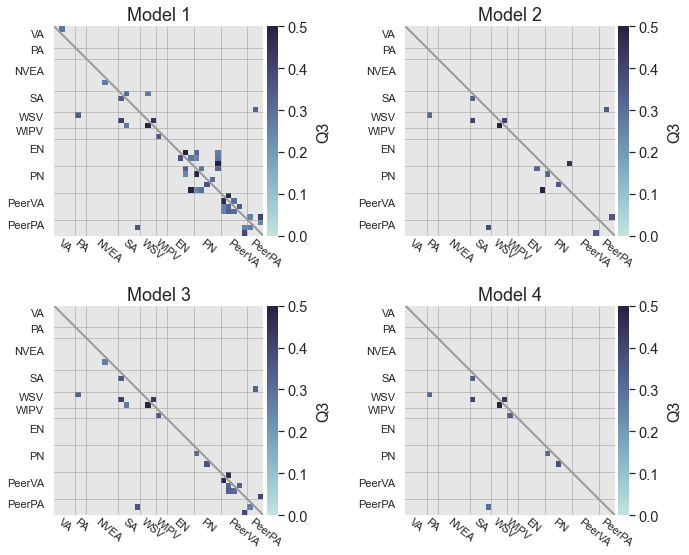

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define I/O parameters.
studies = ['teicher2015','tuominen2022']
models = [1,2,3,4]

## Define threshold.
thresh = 0.99

## Define labels.
titles = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

## Define color palette.
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

## Define item order.
order = dict(
    VA = [0, 1, 2, 3], 
    PA = [5, 6], 
    NVEA = [4, 26, 27, 34, 35, 36], 
    SA = [7, 8, 12, 23], 
    WSV = [9, 10, 11], 
    WIPV = [13, 14], 
    EN = [24, 25, 28, 29, 38], 
    PN = [30, 31, 32, 33, 37], 
    PeerVA = [15, 16, 17, 18, 19], 
    PeerPA = [20, 21, 22]
)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

## Define tick positions.
lengths = [len(v) for v in order.values()]
ticks = [j/2 + np.sum(lengths[:i]) - 1.5 for i, j in enumerate(lengths)]

## Load Q3 indices.
Q3 = read_csv(os.path.join('stan_results', 'Q3.csv'))

## Main loop.
ix = np.concatenate(list(order.values()))
for j, (ax, m) in enumerate(zip(axes.flatten(), models)):
    
    ## Construct SMBC matrix. 
    smbc = np.zeros((ix.max()+1, ix.max()+1))
    for i, study in enumerate(studies):  
        
        ## Preallocate space.
        tmp = np.zeros_like(smbc)
        
        ## Load posterior predictive model check.
        df = Q3.query(f'study == "{study}" and model == {m}')
        
        ## Populate matrix.
        tmp[df.k1, df.k2] = tmp[df.k2, df.k1] = np.where(df.Q3 > df.Q3_99.max(), df.Q3, 0)
        
        ## Reorganize rows / columns.
        tmp = tmp[ix][:,ix]
        
        ## Store.
        if i: smbc += np.triu(tmp)
        else: smbc += np.tril(tmp)
            
    ## Handle colorbar.
    cbar = True
    divider = make_axes_locatable(ax)
    cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
            
    ## Plot background tiles. 
    sns.heatmap(np.identity(len(smbc)), cmap=ListedColormap(['0.9','0.9']), 
                square=True, cbar=False, ax=ax)
            
    ## Plot SMBC.
    sns.heatmap(smbc, cmap=cmap, vmin=0.0, vmax=0.5, cbar=cbar, mask=smbc==0, square=True,
                xticklabels=[], yticklabels=[], ax=ax, cbar_ax=cbar_ax)
    
    ## Draw boundary lines.
    ax.plot([0,40], [0,40], color='0.6', lw=2)
    for k in np.cumsum([len(v) for v in order.values()]): 
        ax.axhline(k, color='0.6', lw=0.5)
        ax.axvline(k, color='0.6', lw=0.5)
        
    ## Add details.
    ax.set(xticks=ticks, yticks=ticks)
    ax.set_xticklabels(order.keys(), ha='left', fontsize=11, rotation=-40)
    ax.set_yticklabels(order.keys(), va='top', fontsize=11, rotation=0)
    ax.tick_params(axis='x', which='major', pad=-5)
    ax.set_title(titles[j], fontsize=18)
    
    ## Update colorbar.
    if cbar:
        cbar = ax.collections[1].colorbar
        cbar.set_label(r'Q3', labelpad=8)
        
plt.tight_layout()
plt.savefig(os.path.join('..', 'figures', 'figS03.png'), dpi=100)